En este notebook vamos a ver como representar datos espaciales en mapas.     
Vamos a utilizar 2 paquetes que functionan de manera similar:
1. [`cartopy`](https://scitools.org.uk/cartopy/)
2. [`Basemap`](https://matplotlib.org/basemap/stable/).

En este notebook nos centraremos sobre la utilización de `cartopy`, mientras `Basemap` será presentado en [datos_espaciales_basemap](datos_espaciales_basemap.ipynb)

## Instalación
Como todos los paquetes de Python, existen varias maneras de instalar `cartopy` y `Basemap`. Lo importante es no mezclar los métodos de instalación. Por ejemplo si paquetes han sido instalado a través de 
```bash
pip install nombre_del_paquete
```
es preferible seguir con este metodo.
### Cartopy
```bash
pip install cartopy
```
Si el comando ha funcionado, se obtendra un mensaje terminando por:
```bash
...
Installing collected packages: shapely, pyshp, pyproj, cartopy
Successfully installed cartopy-0.23.0 pyproj-3.6.1 pyshp-2.3.1 shapely-2.0.6
```
(los números de versiones pueden cambiar).
### Basemap
```bash
pip install basemap
```
Si el comando ha funcionado, se obtendra un mensaje terminando por:
```bash
...
Installing collected packages: basemap-data, Basemap
Successfully installed Basemap-1.4.1 basemap-data-1.3.2
```

In [3]:
import sys
!{sys.executable} -m pip install cartopy
!{sys.executable} -m pip install Basemap

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Preparación de una figura
### Creación de una proyección
La primera etapa consiste en la creación de una proyección, o para ser más preciso: un _Sistema de referencia de coordenadas_ (CRS in inglés: _Coordinate reference system_).

La lista de CRS se encuentra en https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html. En este ejemplo vamos a trabajar con una proyección de Miller.

In [12]:
import os
import netCDF4
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
mainproj = ccrs.Miller()

Se puede visualizar directamente el objeto creado:

In [6]:
mainproj

<Projected CRS: +proj=mill +a=6378137.0 +lon_0=0.0 +no_defs +type= ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Miller Cylindrical
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich

### Selección de una zona de interés
Definimos una variable `domain` que contiene los limites, en el orden (oeste, este, sur, norte).

In [16]:
domain = (-77, -52, -56., -40.)

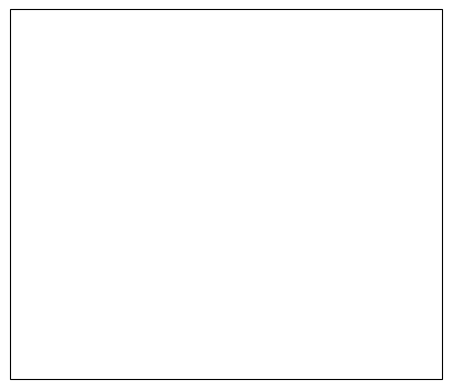

In [17]:
fig = plt.figure()
ax = plt.subplot(111, projection=mainproj)
ax.set_extent(domain)

### Datos 2D
La figura anterior no contiene nada, así que vamos a añadir un campo de temperatura del mar.    

In [18]:
sstfile = "TERRA_MODIS.20000224_20240731.L3m.CU.SST4.sst4.9km.nc"
os.path.exists(sstfile)

True

In [19]:
with netCDF4.Dataset(sstfile, "r") as nc:
    lon = nc.variables["lon"][:]
    lat = nc.variables["lat"][:]
    SST = nc.variables["sst4"][:]

Preparamos una figura básica para comprobar que todo funciona correctamente.

__Importante:__ el argumento `transform=...` en la funcción `pcolormesh`, que indica cual es la proyección de los datos que queremos representar (la SST en este caso).

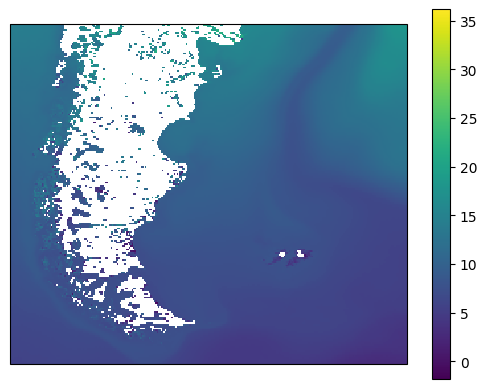

In [22]:
fig = plt.figure()
ax = plt.subplot(111, projection=mainproj)
ax.set_extent(domain)
pcm = ax.pcolormesh(lon, lat, SST, transform=ccrs.PlateCarree())
cb = plt.colorbar(pcm)
plt.show()

### Decoración del mapa